In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import asyncio
import aiohttp
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import sklearn
from ast import literal_eval
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
pd.options.display.max_rows = 200
pd.options.display.max_columns = 50
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
idr_gr38 = pd.read_table('quality_metric_distribution/data/idr_data_original_GRCh38_06_21_2017.tsv')
idr_hg19 = pd.read_table('quality_metric_distribution/data/idr_data_original_hg19_06_21_2017.tsv')
new_gr38 = pd.read_table('quality_metric_distribution/data/idr_metrics_GRCh38_06_30_2017.tsv')
new_hg19 = pd.read_table('quality_metric_distribution/data/idr_metrics_hg19_06_30_2017.tsv')

## Summary statistics

In [4]:
idr_gr38.describe()

,Nt,Np,N1,N2,rescue_ratio,self_consistency_ratio,Ft,Fp,F1,F2,total_price
count,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1404.000000,1404.000000,1404.000000,1404.000000,1571.000000
mean,16431.189567,19374.104962,13764.267176,13672.756361,1.912867,2.471204,0.050405,0.054444,0.048786,0.046469,4.386750
std,17386.636011,18296.462552,15397.602386,15083.206504,5.816754,6.418202,0.069206,0.069926,0.070210,0.065275,10.922887
min,4.000000,14.000000,3.000000,4.000000,1.000032,1.000000,0.000017,0.000135,0.000030,0.000067,0.058530
25%,3053.750000,4723.250000,2290.750000,2350.500000,1.107222,1.159298,0.006031,0.007433,0.005292,0.005047,0.166708
50%,10015.000000,13627.000000,7771.000000,7740.000000,1.265464,1.411646,0.023116,0.027385,0.019673,0.018330,0.207025
75%,24489.500000,29186.250000,20075.500000,20532.250000,1.584466,1.909372,0.065393,0.070570,0.060971,0.059427,0.266069
max,100423.000000,106703.000000,101695.000000,93494.000000,189.153846,142.535211,0.585003,0.588346,0.553675,0.526923,63.604375


In [5]:
new_gr38.replace('not_available', np.nan).apply(lambda x: pd.to_numeric(x, errors='ignore')).describe()

,Nt,Np,N1,N2,rescue_ratio,self_consistency_ratio,Ft,Fp,F1,F2
count,1589.000000,1589.000000,1727.000000,1589.000000,1589.000000,1589.000000,1421.000000,1421.000000,1491.000000,1421.000000
mean,16354.103839,19297.801762,14020.614360,13626.676526,1.909976,2.470875,0.050036,0.054059,0.050542,0.046180
std,17333.250601,18240.826359,16047.607337,15033.490079,5.786714,6.392753,0.068909,0.069633,0.077205,0.064980
min,4.000000,14.000000,3.000000,4.000000,1.000032,1.000000,0.000017,0.000135,0.000012,0.000067
25%,3041.000000,4712.000000,2193.000000,2364.000000,1.108885,1.160023,0.005958,0.007429,0.004890,0.005051
50%,9994.000000,13571.000000,7628.000000,7715.000000,1.266974,1.413914,0.022755,0.027191,0.019338,0.018327
75%,24440.000000,29126.000000,20331.000000,20527.000000,1.584562,1.910861,0.064756,0.070132,0.061625,0.059144
max,100423.000000,106703.000000,101695.000000,93494.000000,189.153846,142.535211,0.585003,0.588346,0.790521,0.526923


In [6]:
idr_hg19.describe()

,Nt,Np,N1,N2,rescue_ratio,self_consistency_ratio,Ft,Fp,F1,F2,total_price
count,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,60.000000,60.000000,60.000000,60.000000,1350.000000
mean,15678.586973,18808.208734,13555.929682,13295.282754,1.927984,2.371005,0.048368,0.054220,0.049833,0.046219,25.310565
std,17093.255660,18309.829743,15449.642659,14932.080833,4.981650,7.205406,0.056170,0.059428,0.055805,0.056265,19.516770
min,18.000000,26.000000,10.000000,12.000000,1.000000,1.000620,0.000101,0.000405,0.000333,0.000227,0.013735
25%,2466.500000,4098.500000,2134.500000,2045.000000,1.111129,1.145248,0.004094,0.005077,0.004892,0.002759,13.697048
50%,8817.000000,12539.000000,7376.000000,7100.000000,1.296755,1.391343,0.022760,0.029349,0.022993,0.019652,25.323867
75%,23558.000000,28641.500000,19649.500000,20283.500000,1.626197,1.889803,0.087218,0.100524,0.100174,0.069992,31.474489
max,96619.000000,134543.000000,130202.000000,93654.000000,110.185366,191.302632,0.193167,0.201301,0.199127,0.212596,121.788247


In [7]:
new_hg19.replace('not_available', np.nan).apply(lambda x: pd.to_numeric(x, errors='ignore')).describe()

,Nt,Np,N1,N2,rescue_ratio,self_consistency_ratio,Ft,Fp,F1,F2
count,1363.000000,1363.000000,1500.00000,1363.000000,1363.000000,1363.000000,72.000000,72.000000,142.000000,72.000000
mean,15642.526779,18779.597946,13853.48600,13285.687454,1.927027,2.373375,0.044133,0.049584,0.067973,0.042849
std,17045.156525,18253.646601,16175.30457,14886.334590,4.960964,7.182043,0.052916,0.055965,0.121407,0.052662
min,18.000000,26.000000,2.00000,12.000000,1.000000,1.000620,0.000101,0.000405,0.000002,0.000227
25%,2489.000000,4103.000000,2030.75000,2074.000000,1.112537,1.146407,0.004461,0.006559,0.001654,0.005755
50%,8838.000000,12546.000000,7193.50000,7163.000000,1.299340,1.391343,0.020522,0.026142,0.013026,0.019908
75%,23490.500000,28554.000000,20031.25000,20283.500000,1.626197,1.889803,0.073271,0.087923,0.096662,0.062344
max,96619.000000,134543.000000,130202.00000,93654.000000,110.185366,191.302632,0.193167,0.201301,0.789523,0.212596


In [8]:
new_gr38

,date,analysis,uuid,experiment,target,biosample_term_name,biosample_type,lab,rfa,assembly,Nt,Np,N1,N2,rescue_ratio,self_consistency_ratio,reproducibility_test,Ft,Fp,F1,F2,state,release,quality_metric_of
0,2017-06-09T01:35:54.882443+00:00,https://www.encodeproject.org/analysis-step-ru...,2e7d4b38-aa64-4f30-bd40-072143bc8208,https://www.encodeproject.org/experiments/ENCS...,ZNF274-human,GM08714,immortalized cell line,peggy-farnham,ENCODE2,GRCh38,920,1004,752,843,1.0913043478260869,1.1210106382978724,pass,0.004266437505030991,0.00450723330717218,0.0038787581584199234,0.004457696119264219,done,released,"[u'/files/ENCFF897HDW/', u'/files/ENCFF329TZO/']"
1,2017-06-09T01:32:24.178350+00:00,https://www.encodeproject.org/analysis-step-ru...,50016ba5-1050-4ffb-a0d0-4a05bbb88a48,https://www.encodeproject.org/experiments/ENCS...,JUND-human,MCF-7,immortalized cell line,richard-myers,ENCODE2,GRCh38,10788,14668,6196,9040,1.3596588802373006,1.459005810200129,pass,0.024894580765019648,0.030409933543941264,0.020067343279784693,0.022519052686713767,done,released,"[u'/files/ENCFF918BVV/', u'/files/ENCFF569ZCY/']"
2,2017-05-23T23:44:41.769815+00:00,https://www.encodeproject.org/analysis-step-ru...,27359c37-3d2d-4aac-90f9-4bfe12b800d1,https://www.encodeproject.org/experiments/ENCS...,USF1-human,K562,immortalized cell line,richard-myers,ENCODE2,GRCh38,14182,21382,16367,5891,1.507685798900014,2.7783058903411986,borderline,0.09668138508786722,0.11224134809578616,0.09534837462507277,0.0882317664320779,done,released,"[u'/files/ENCFF717KGR/', u'/files/ENCFF409EYL/']"
3,2017-06-09T01:42:32.202443+00:00,https://www.encodeproject.org/analysis-step-ru...,e62fdecb-5c63-4a22-8209-7aff114d9717,https://www.encodeproject.org/experiments/ENCS...,ARID3A-human,K562,immortalized cell line,michael-snyder,ENCODE2,GRCh38,10619,11463,8206,2266,1.0794801770411526,3.621359223300971,borderline,0.020823081764173045,0.02183071408082467,0.017614956448477534,0.007294785693164625,done,released,"[u'/files/ENCFF272CWK/', u'/files/ENCFF757OML/']"
4,2017-06-09T01:08:24.850590+00:00,https://www.encodeproject.org/analysis-step-ru...,0835f6e5-80ad-42bc-a7cf-f863b4a79bf4,https://www.encodeproject.org/experiments/ENCS...,CTCF-human,K562,immortalized cell line,john-stamatoyannopoulos,ENCODE2,GRCh38,39447,44723,37639,23356,1.1337490810454534,1.61153450933379,pass,0.20429701261717428,0.2121795084897384,0.20121022094020669,0.17612375914691775,done,released,"[u'/files/ENCFF389ELU/', u'/files/ENCFF843VHC/']"
5,2016-12-16T08:42:37.639744+00:00,https://www.encodeproject.org/analysis-step-ru...,660973c4-c1dc-4772-b1c4-56ee992e8f87,https://www.encodeproject.org/experiments/ENCS...,RXRA-human,HepG2,immortalized cell line,richard-myers,ENCODE2,GRCh38,12197,26124,4332,25646,2.141838156923834,5.920129270544783,fail,not_available,not_available,not_available,not_available,done,released,"[u'/files/ENCFF141JYN/', u'/files/ENCFF105TFM/']"
6,2017-06-09T01:20:08.975166+00:00,https://www.encodeproject.org/analysis-step-ru...,615c1ff3-f02d-48df-8663-afc8d3e27eb6,https://www.encodeproject.org/experiments/ENCS...,JUND-human,GM12878,immortalized cell line,michael-snyder,ENCODE2,GRCh38,6987,7452,4805,2488,1.0665521683125805,1.9312700964630225,pass,0.01336072133131294,0.013942925907516708,0.00986593871703258,0.010908948354428277,done,released,"[u'/files/ENCFF330LVI/', u'/files/ENCFF873DJD/']"
7,2017-05-17T06:16:38.913939+00:00,https://www.encodeproject.org/analysis-step-ru...,324db417-5a13-4b89-ab9d-00a91c0a95c7,https://www.encodeproject.org/experiments/ENCS...,NKRF-human,MCF-7,immortalized cell line,michael-snyder,ENCODE3,GRCh38,224,1960,3914,516,8.75,7.5852713178294575,fail,0.00036649138468563023,0.0021017987544353855,0.005520505460597057,0.0007564330929755675,done,submitted,"[u'/files/ENCFF886OCK/', u'/files/ENCFF357AHA/']"
8,2017-06-09T01:44:27.322619+00:00,https://www.encodeproject.org/analysis-step-ru...,637b89ac-2644-48c0-a878-bdc4f6679e74,https://www.encodeproject.org/experiments/ENCS...,TCF12-human,GM12878

## Distributions of metrics

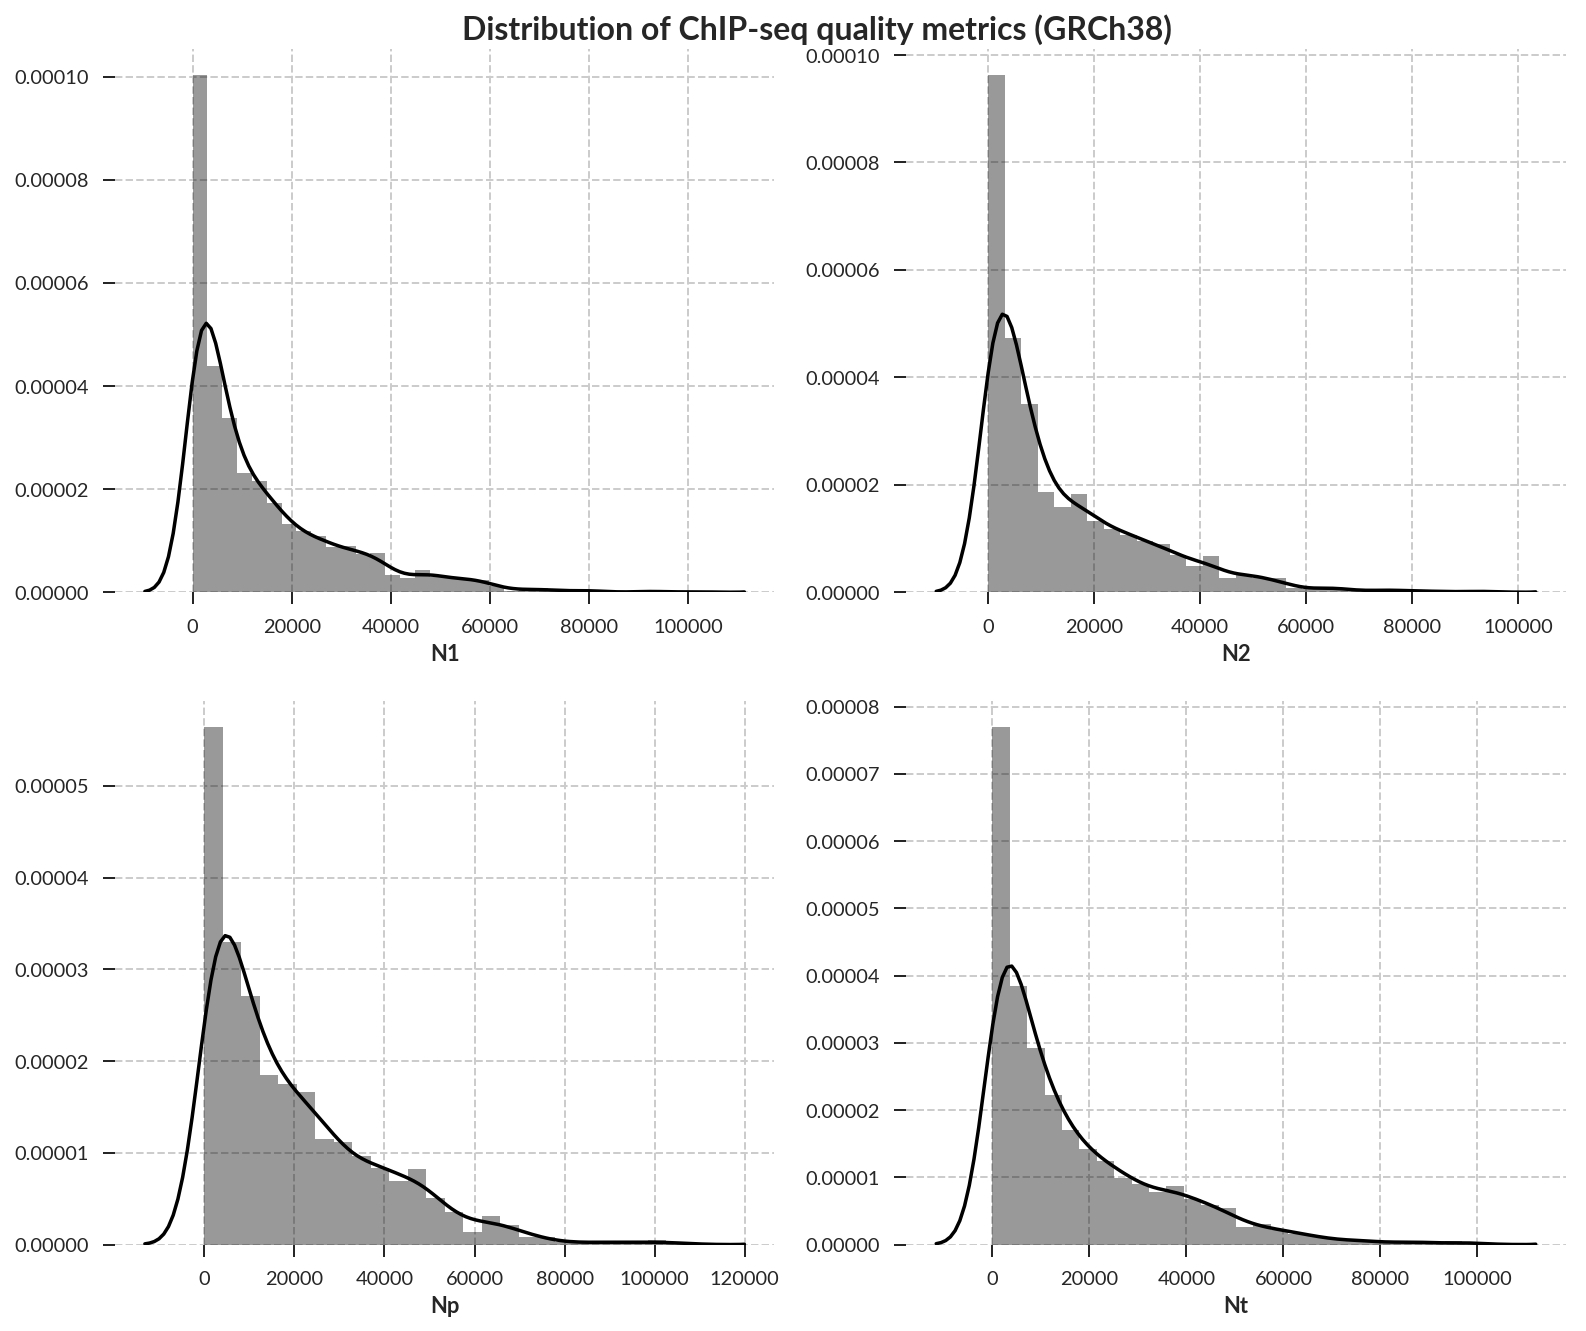

In [5]:
sns.set(style="ticks", font="Lato")
fig = plt.figure(figsize=[13, 11])
with sns.plotting_context("notebook", font_scale=1):
    for i, y in enumerate(['N1', 'N2', 'Np','Nt']):
        plt.subplot(2, 2, i + 1)
        sns.distplot(idr_gr38[y].dropna(), color='black')
        sns.despine(left=True, bottom=True)
        fig.gca().yaxis.grid(True, ls="--")
        fig.gca().xaxis.grid(True, ls="--")
        x_label = fig.gca().get_xlabel()
        fig.gca().set_xlabel(xlabel=x_label, weight='bold')
fig.suptitle('Distribution of ChIP-seq quality metrics (GRCh38)',
              size=16,
              family='Lato',
              fontweight='bold',
              y=0.902);

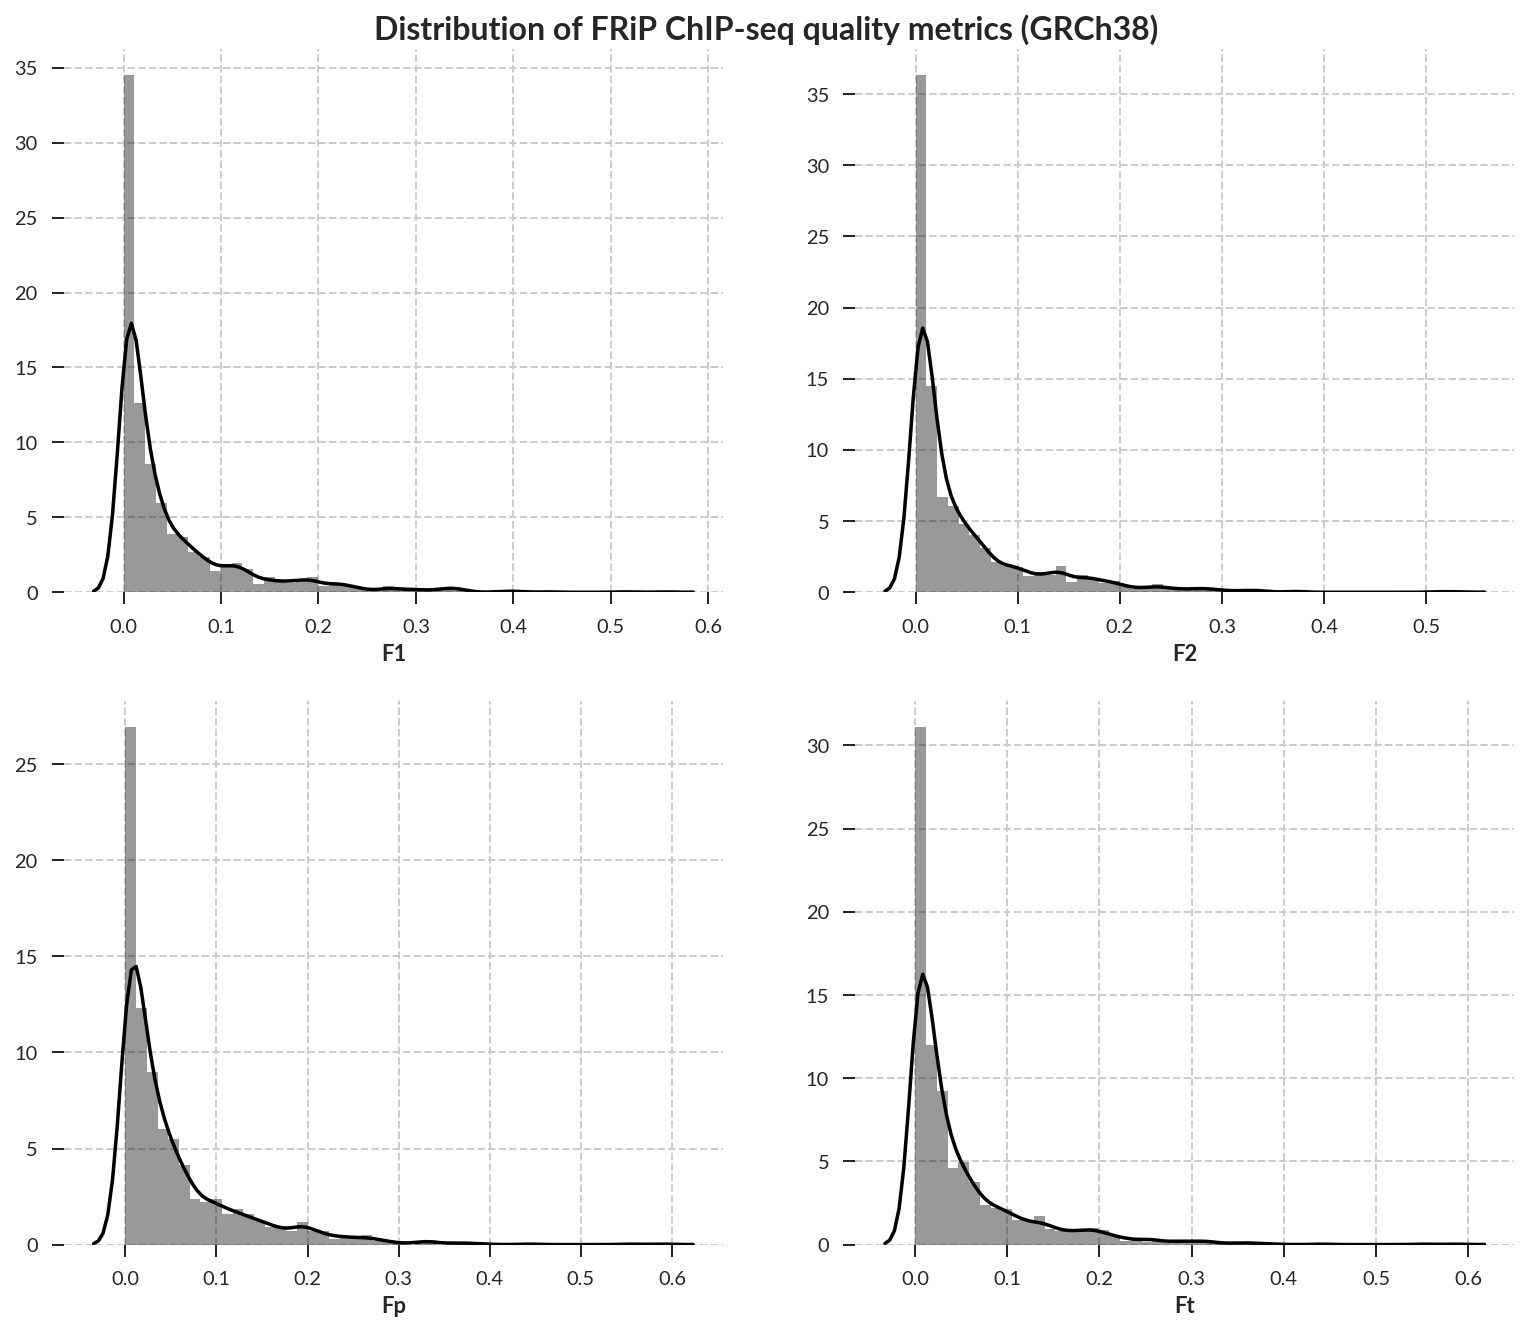

In [6]:
sns.set(style="ticks", font="Lato")
fig = plt.figure(figsize=[13, 11])
with sns.plotting_context("notebook", font_scale=1):
    for i, y in enumerate(['F1', 'F2', 'Fp', 'Ft']):
        plt.subplot(2, 2, i + 1)
        sns.distplot(idr_gr38[y].dropna(), color='black')
        sns.despine(left=True, bottom=True)
        fig.gca().yaxis.grid(True, ls="--")
        fig.gca().xaxis.grid(True, ls="--")
        x_label = fig.gca().get_xlabel()
        fig.gca().set_xlabel(xlabel=x_label, weight='bold')
    
fig.suptitle('Distribution of FRiP ChIP-seq quality metrics (GRCh38)',
              size=16,
              family='Lato',
              fontweight='bold',
              y=0.902);

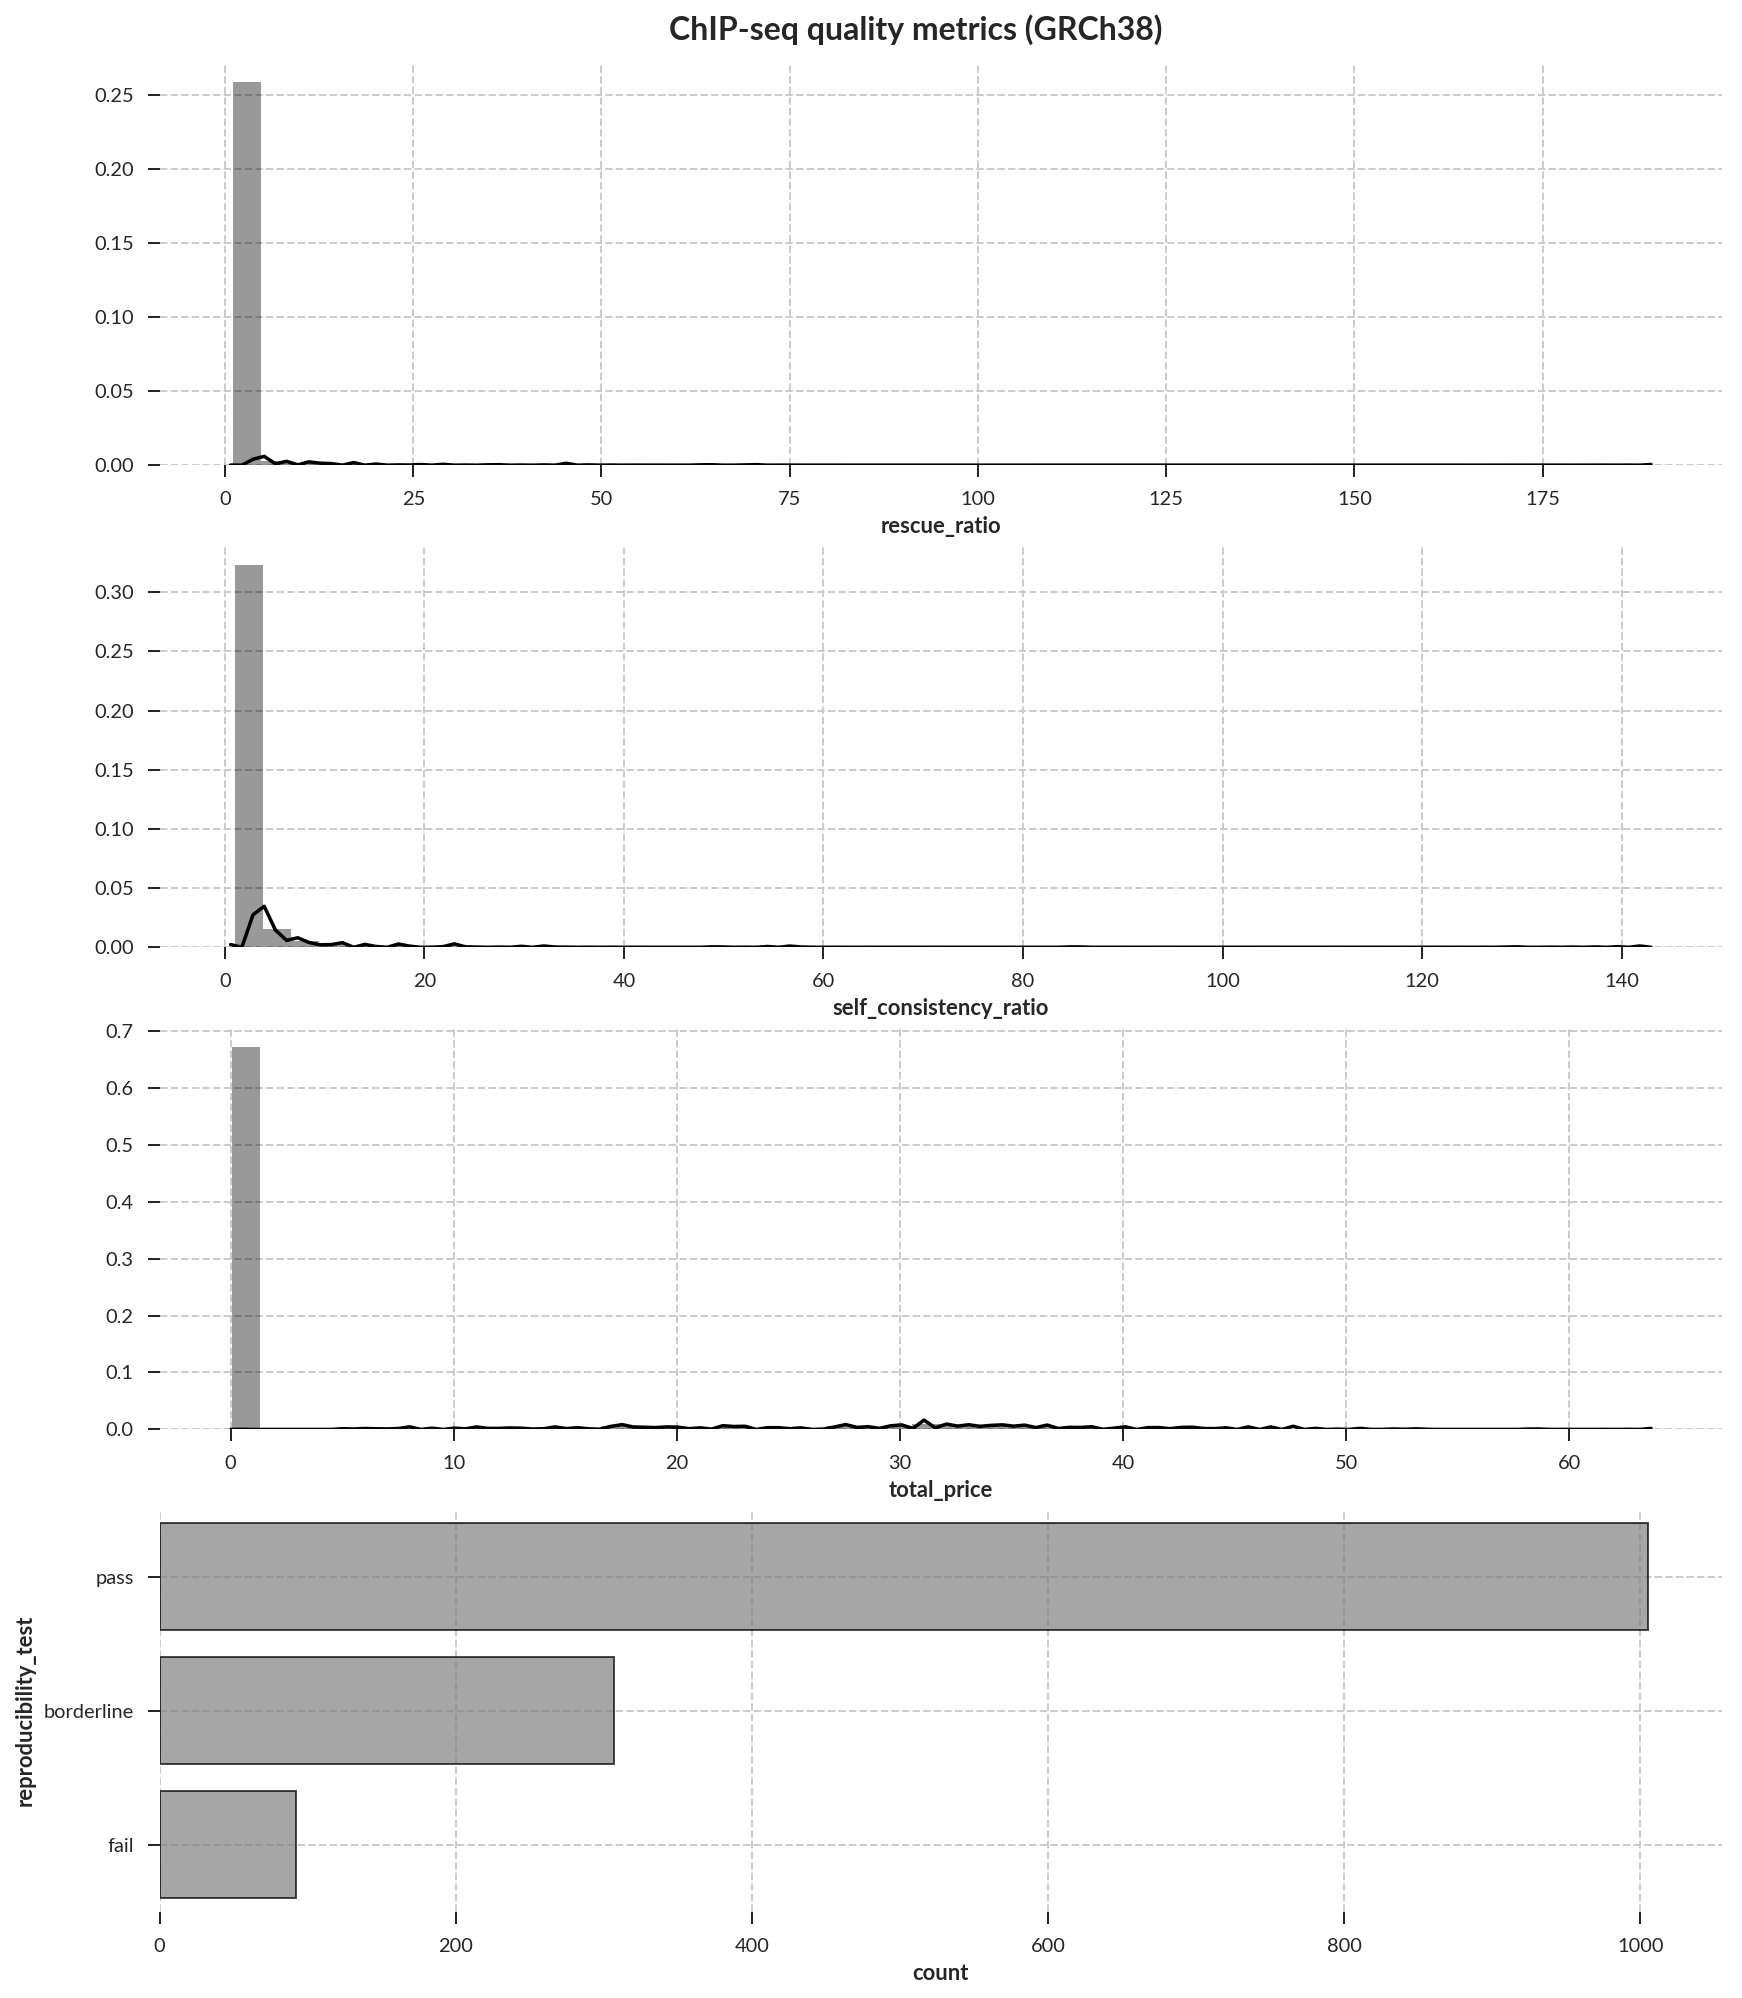

In [7]:
sns.set(style="ticks", font="Lato")
fig = plt.figure(figsize=[14, 17])
with sns.plotting_context("notebook", font_scale=1):
    for i, y in enumerate(['rescue_ratio', 'self_consistency_ratio', 'total_price']):
        plt.subplot(4, 1, i + 1)
        sns.distplot(idr_gr38[y].dropna(), color='black')
        sns.despine(left=True, bottom=True)
        fig.gca().yaxis.grid(True, ls="--")
        fig.gca().xaxis.grid(True, ls="--")
        x_label = fig.gca().get_xlabel()
        fig.gca().set_xlabel(xlabel=x_label, weight='bold')

plt.subplot2grid((4, 1), (3, 0), colspan=1)
sns.countplot(y='reproducibility_test',
              data=idr_gr38.dropna(),
              order=['pass', 'borderline', 'fail'],
              color='gray',
              edgecolor='black',
              linewidth=1,
              alpha=0.7)
sns.despine(left=True, bottom=True)
fig.gca().yaxis.grid(True, ls="--")
fig.gca().xaxis.grid(True, ls="--")
y_label = fig.gca().get_ylabel()
fig.gca().set_ylabel(ylabel=y_label, weight='bold')
x_label = fig.gca().get_xlabel()
fig.gca().set_xlabel(xlabel=x_label, weight='bold')

fig.suptitle('ChIP-seq quality metrics (GRCh38)',
              size=16,
              family='Lato',
              fontweight='bold',
              y=0.900);

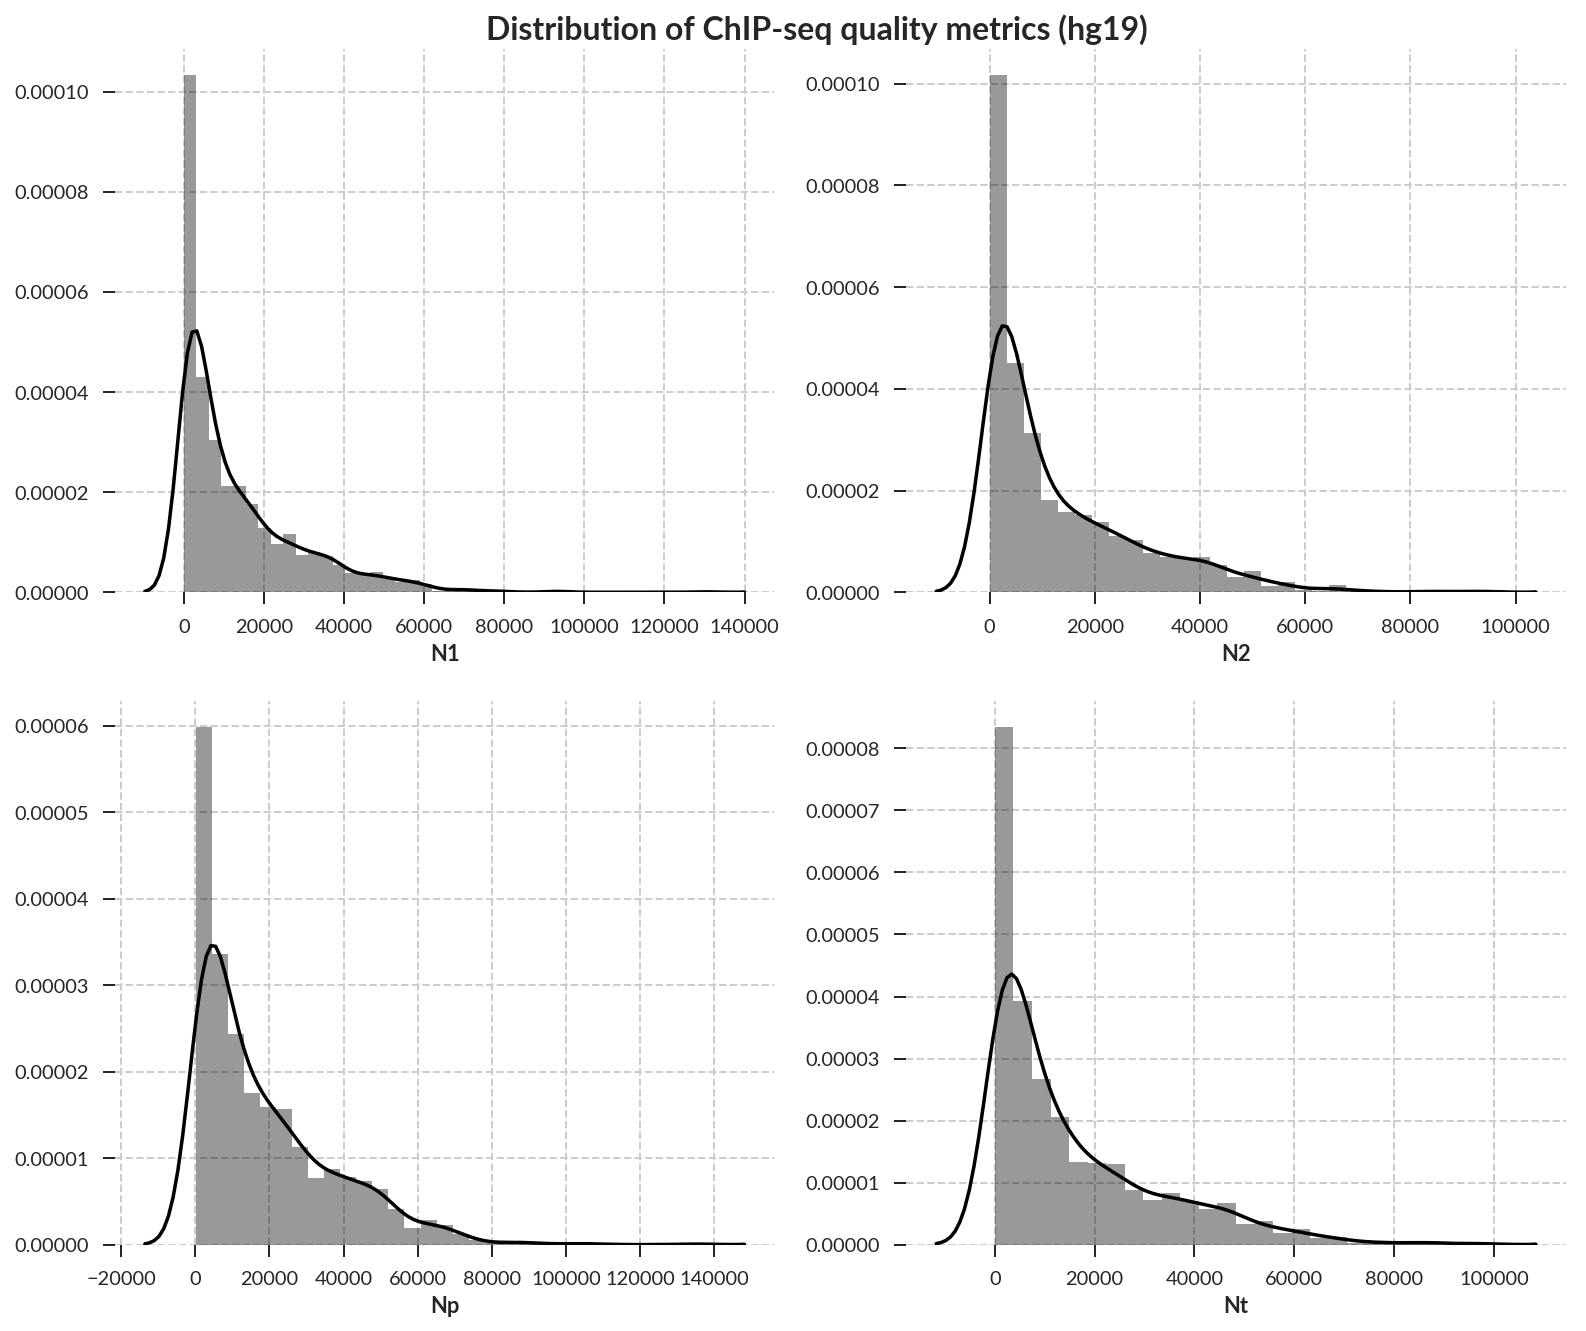

In [8]:
sns.set(style="ticks", font="Lato")
fig = plt.figure(figsize=[13, 11])
with sns.plotting_context("notebook", font_scale=1):
    for i, y in enumerate(['N1', 'N2', 'Np','Nt']):
        plt.subplot(2, 2, i + 1)
        sns.distplot(idr_hg19[y].dropna(), color='black')
        sns.despine(left=True, bottom=True)
        fig.gca().yaxis.grid(True, ls="--")
        fig.gca().xaxis.grid(True, ls="--")
        x_label = fig.gca().get_xlabel()
        fig.gca().set_xlabel(xlabel=x_label, weight='bold')
fig.suptitle('Distribution of ChIP-seq quality metrics (hg19)',
              size=16,
              family='Lato',
              fontweight='bold',
              y=0.902);

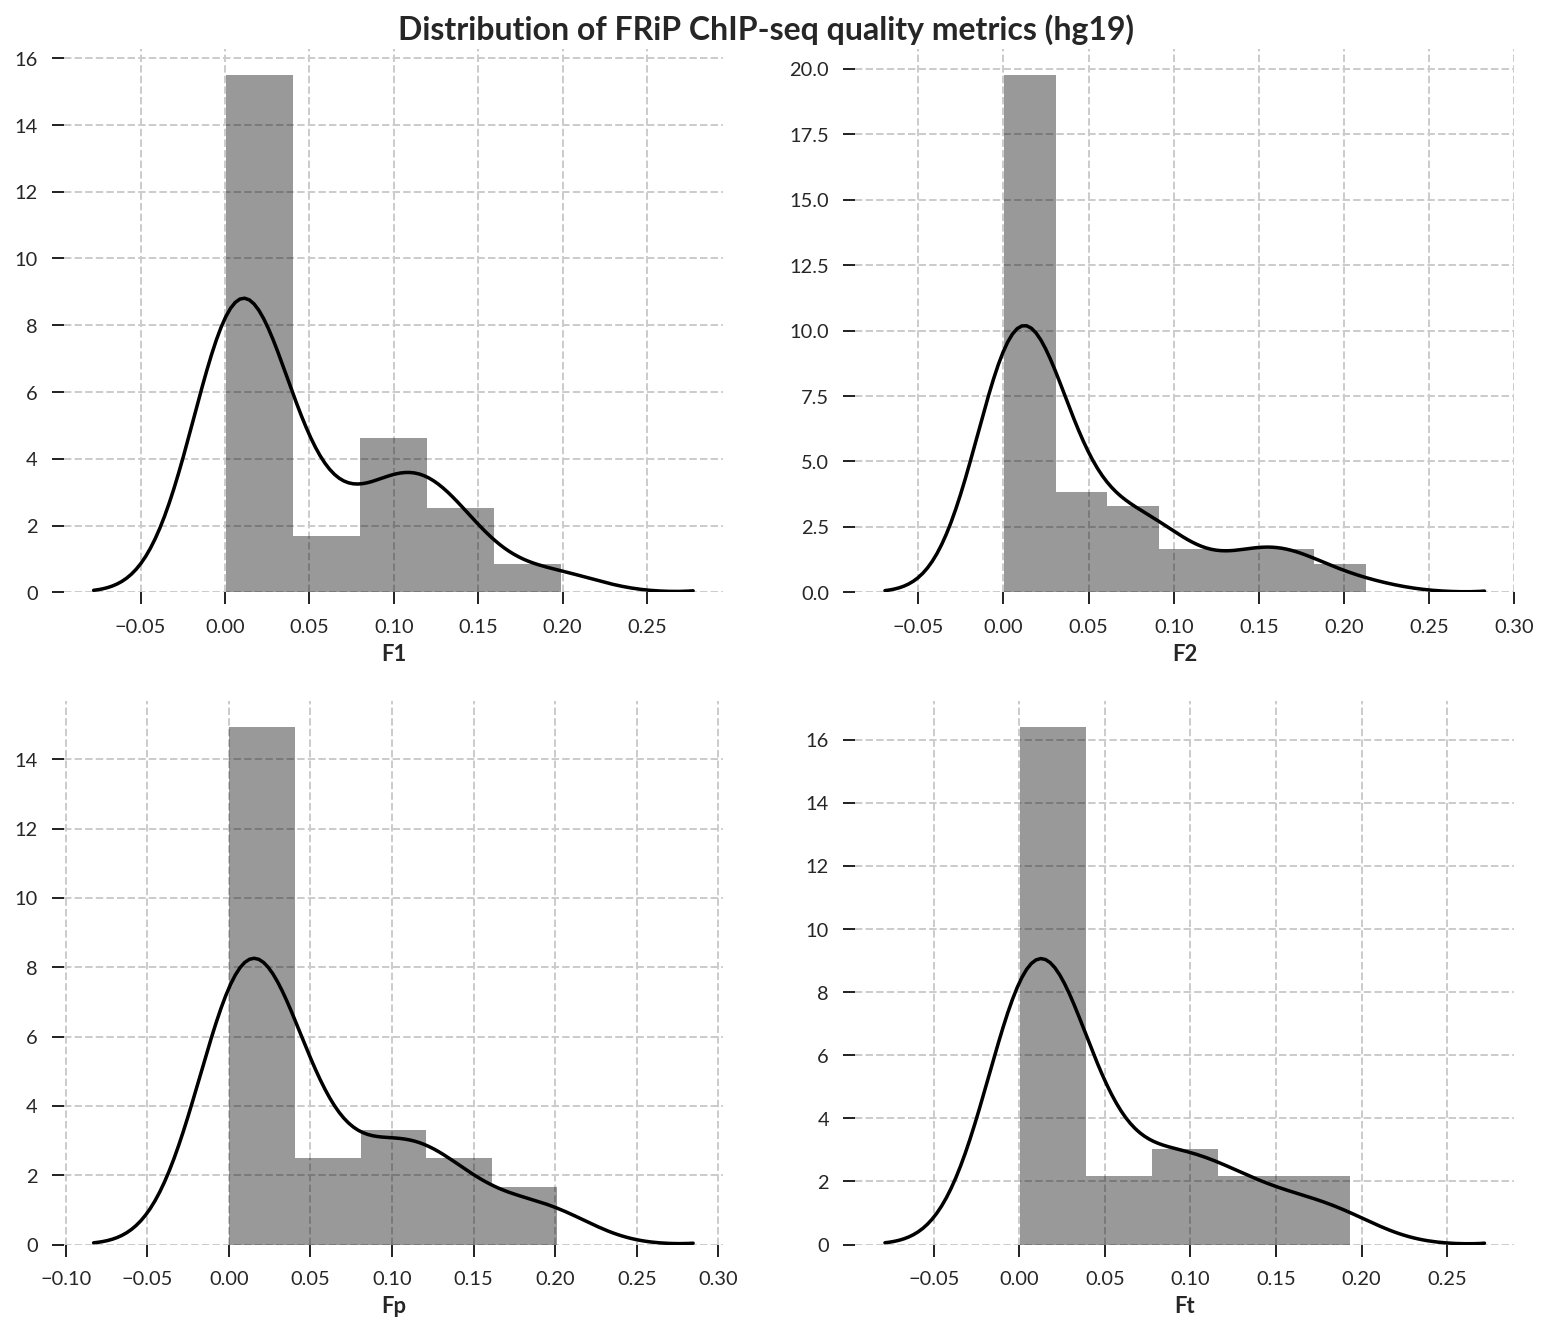

In [9]:
sns.set(style="ticks", font="Lato")
fig = plt.figure(figsize=[13, 11])
with sns.plotting_context("notebook", font_scale=1):
    for i, y in enumerate(['F1', 'F2', 'Fp', 'Ft']):
        plt.subplot(2, 2, i + 1)
        sns.distplot(idr_hg19[y].dropna(), color='black')
        sns.despine(left=True, bottom=True)
        fig.gca().yaxis.grid(True, ls="--")
        fig.gca().xaxis.grid(True, ls="--")
        x_label = fig.gca().get_xlabel()
        fig.gca().set_xlabel(xlabel=x_label, weight='bold')
    
fig.suptitle('Distribution of FRiP ChIP-seq quality metrics (hg19)',
              size=16,
              family='Lato',
              fontweight='bold',
              y=0.902);

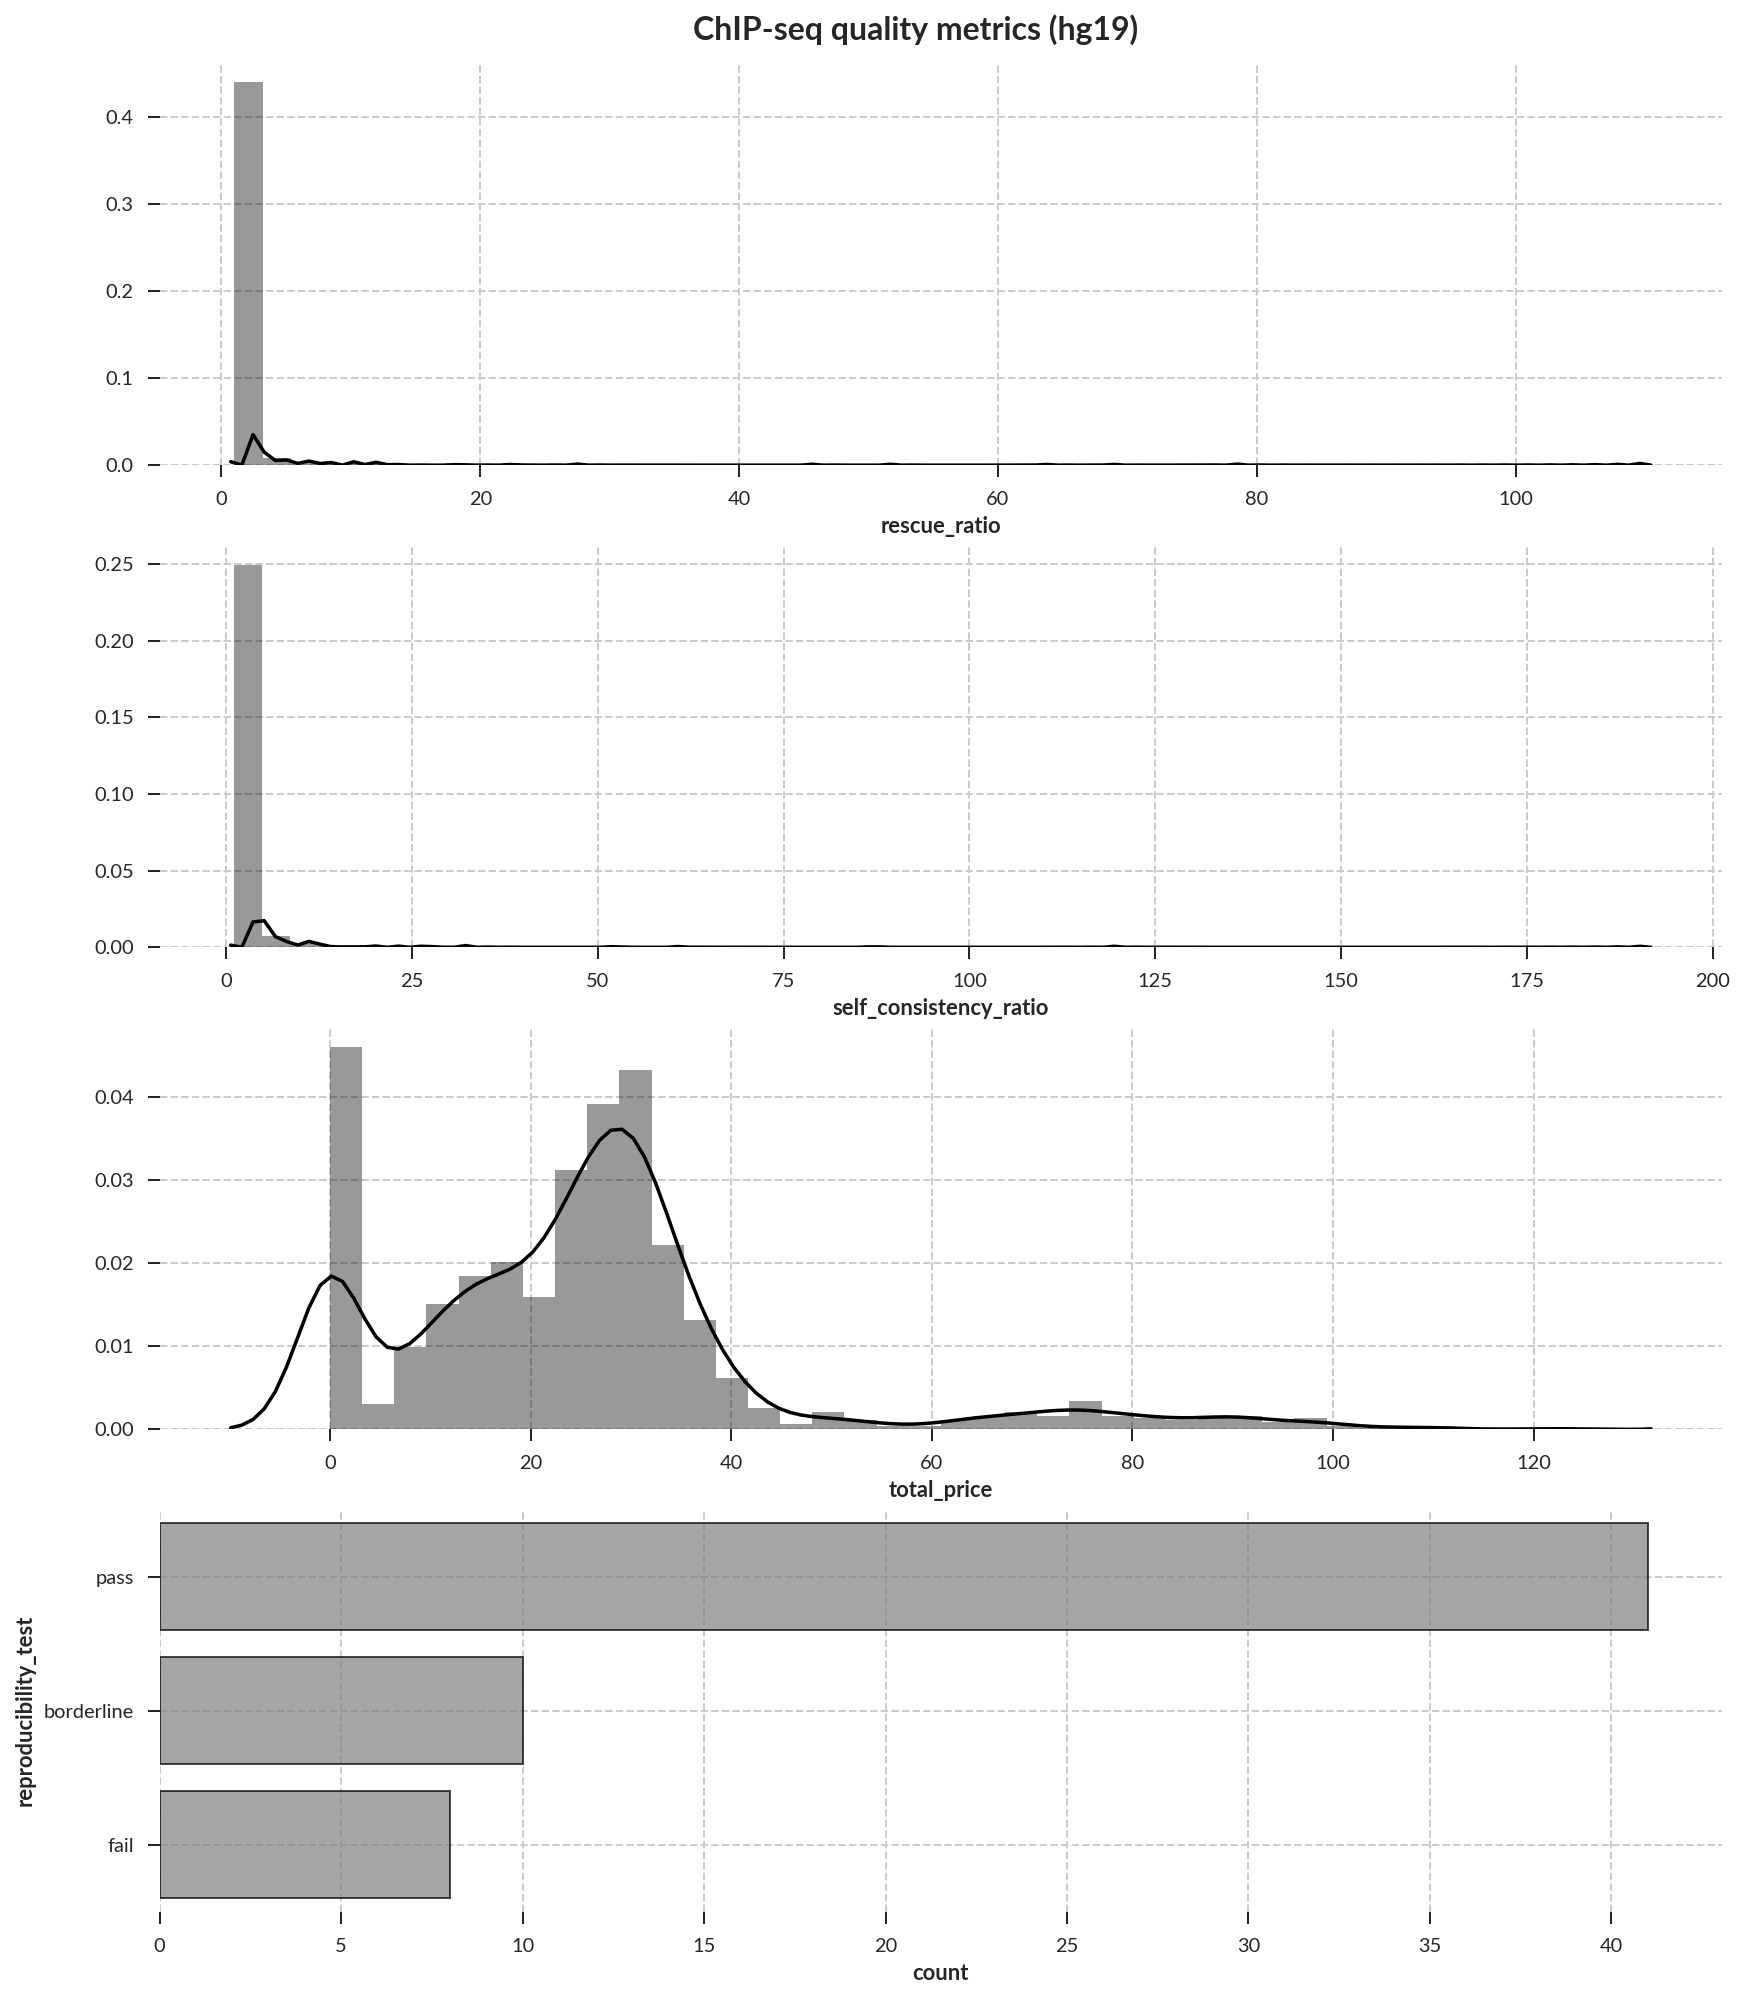

In [10]:
sns.set(style="ticks", font="Lato")
fig = plt.figure(figsize=[14, 17])
with sns.plotting_context("notebook", font_scale=1):
    for i, y in enumerate(['rescue_ratio', 'self_consistency_ratio', 'total_price']):
        plt.subplot(4, 1, i + 1)
        sns.distplot(idr_hg19[y].dropna(), color='black')
        sns.despine(left=True, bottom=True)
        fig.gca().yaxis.grid(True, ls="--")
        fig.gca().xaxis.grid(True, ls="--")
        x_label = fig.gca().get_xlabel()
        fig.gca().set_xlabel(xlabel=x_label, weight='bold')

plt.subplot2grid((4, 1), (3, 0), colspan=1)
sns.countplot(y='reproducibility_test',
              data=idr_hg19.dropna(),
              order=['pass', 'borderline', 'fail'],
              color='gray',
              edgecolor='black',
              linewidth=1,
              alpha=0.7)
sns.despine(left=True, bottom=True)
fig.gca().yaxis.grid(True, ls="--")
fig.gca().xaxis.grid(True, ls="--")
y_label = fig.gca().get_ylabel()
fig.gca().set_ylabel(ylabel=y_label, weight='bold')
x_label = fig.gca().get_xlabel()
fig.gca().set_xlabel(xlabel=x_label, weight='bold')

fig.suptitle('ChIP-seq quality metrics (hg19)',
              size=16,
              family='Lato',
              fontweight='bold',
              y=0.900);

## t-SNE applied to numerical metrics

#### *For GRCh38:*

In [11]:
idr_num = idr_gr38[['Nt',
                    'Np',
                    'N1',
                    'N2',
                    'rescue_ratio',
                    'self_consistency_ratio',
                    'Ft',
                    'Fp',
                    'F1',
                    'F2',
                    'reproducibility_test']].dropna().reset_index(drop=True)

idr_num_X = idr_num[['Nt',
                     'Np',
                     'N1',
                     'N2',
                     'rescue_ratio',
                     'self_consistency_ratio',
                     'Ft',
                     'Fp',
                     'F1',
                     'F2']]

idr_num_Y = idr_num[['reproducibility_test']]

In [12]:
x = idr_num_X.values
standard_scaler = StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
tsne = TSNE(n_components=2, perplexity=50, n_iter=5000, init='pca')
x_test_2d = tsne.fit_transform(x_scaled)

In [13]:
data = pd.concat([pd.DataFrame(x_test_2d), pd.DataFrame(idr_num_Y)], axis=1)
data = data.rename(columns={0:'x', 1:'y'})

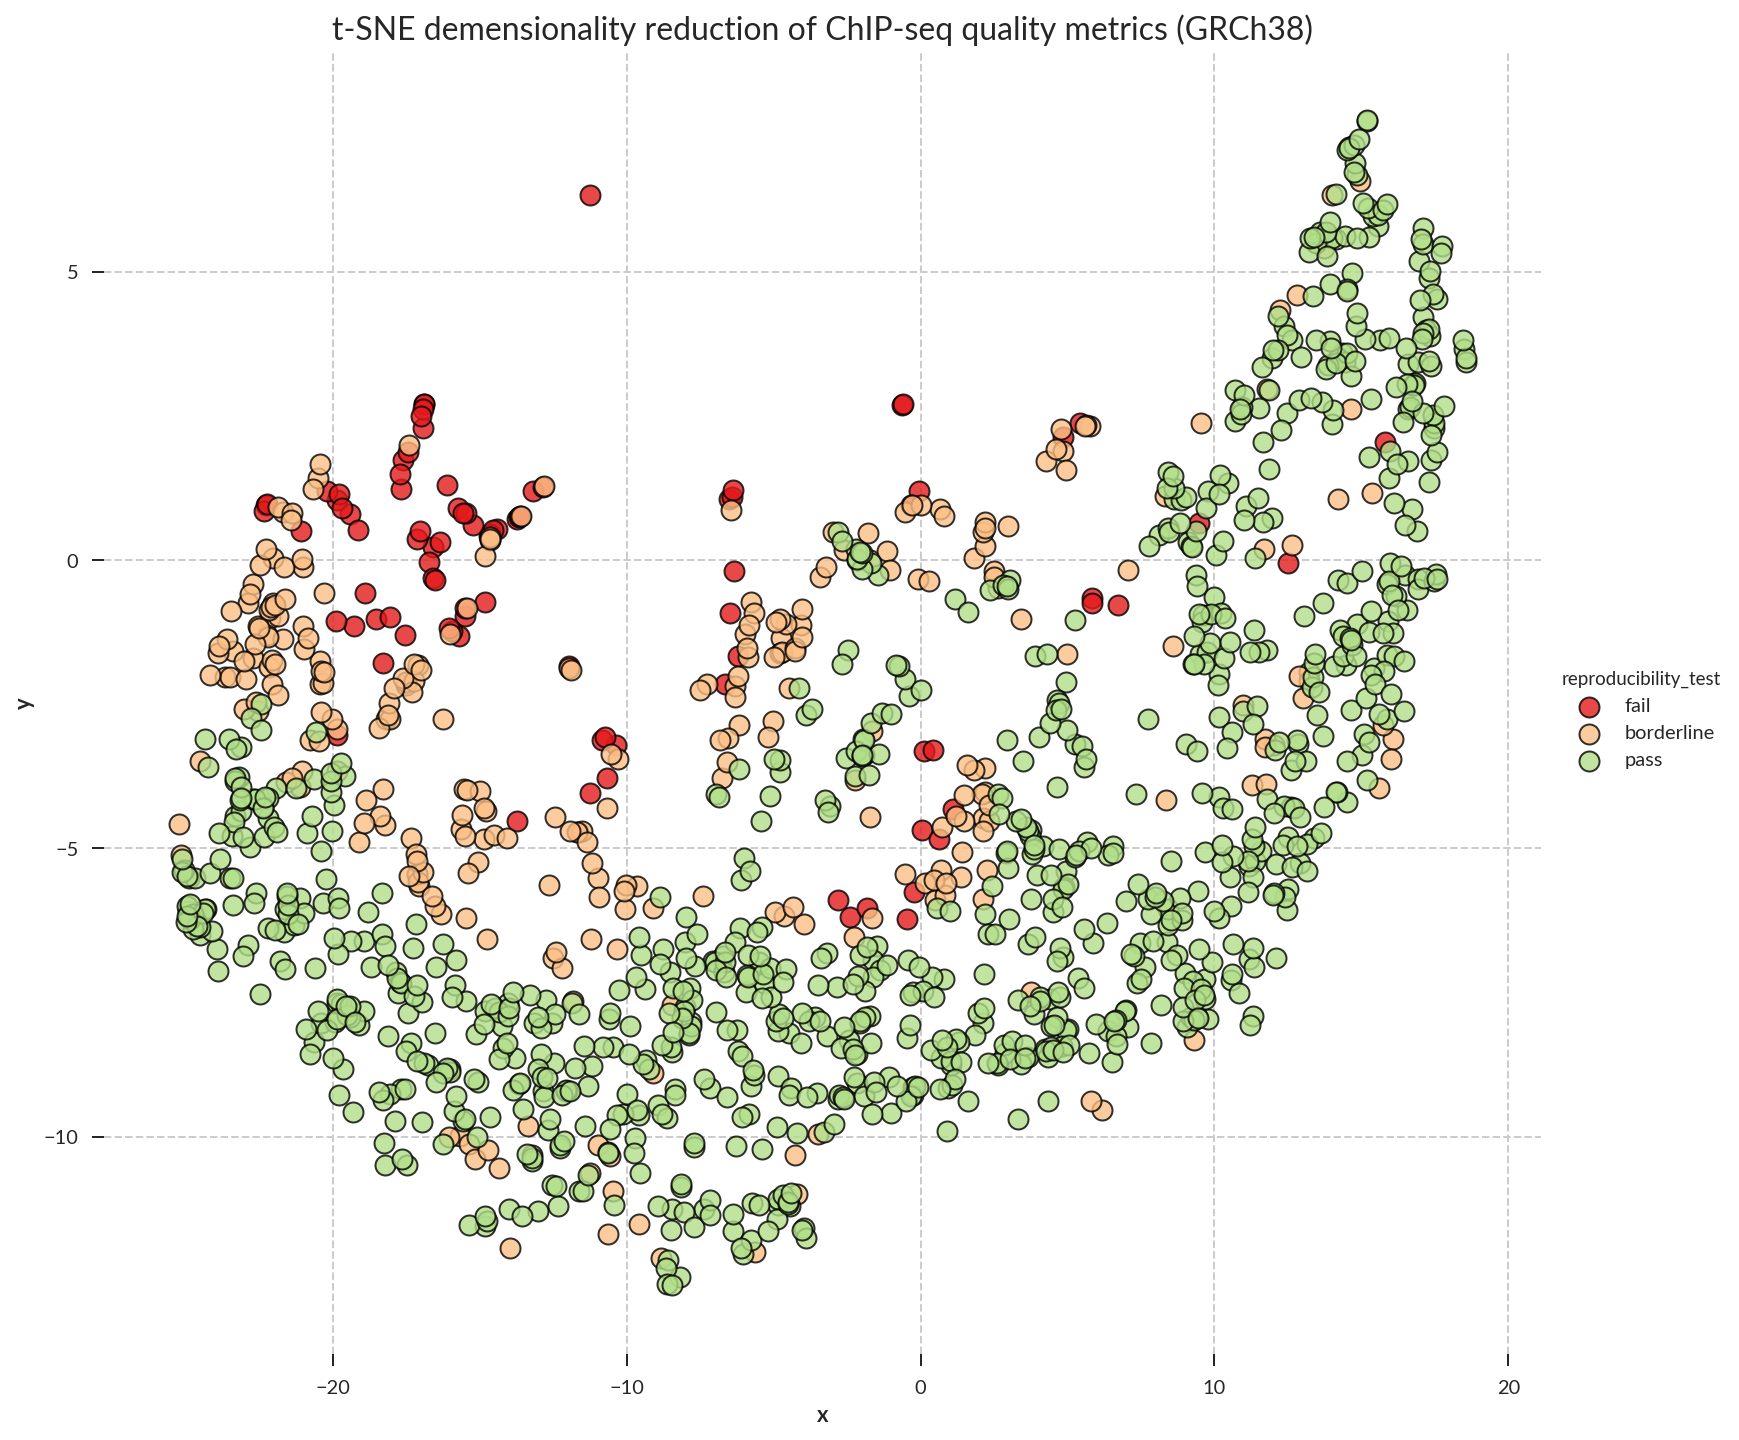

In [14]:
sns.set(style="ticks", font="Lato")
with sns.plotting_context("notebook", font_scale=1):
    sns.lmplot(x='x',
               y='y',
               hue='reproducibility_test',
               hue_order=['fail', 'borderline', 'pass'],
               data=data,
               size=10,
               aspect=1.1,
               fit_reg=False,
               palette=['#e41a1c','#fdc086','#b2df8a'],
               scatter_kws={'s': 100,
                            'linewidth': 1,
                            'edgecolor': "black"})
sns.despine(left=True, bottom=True)
sns.plt.gca().yaxis.grid(True, ls="--")
sns.plt.gca().xaxis.grid(True, ls="--")
y_label = sns.plt.gca().get_ylabel()
sns.plt.gca().set_ylabel(ylabel=y_label, weight='bold')
x_label = sns.plt.gca().get_xlabel()
sns.plt.gca().set_xlabel(xlabel=x_label, weight='bold')
sns.plt.title("t-SNE demensionality reduction of ChIP-seq quality metrics (GRCh38)", size=16, family='Lato');

#### *For hg19*

In [15]:
idr_num = idr_hg19[['Nt',
                    'Np',
                    'N1',
                    'N2',
                    'rescue_ratio',
                    'self_consistency_ratio',
                    'reproducibility_test']].dropna().reset_index(drop=True)

idr_num_X = idr_num[['Nt',
                     'Np',
                     'N1',
                     'N2',
                     'rescue_ratio',
                     'self_consistency_ratio']]

idr_num_Y = idr_num[['reproducibility_test']]

In [16]:
x = idr_num_X.values
standard_scaler = StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
tsne = TSNE(n_components=2, perplexity=50, n_iter=5000, init='pca')
x_test_2d = tsne.fit_transform(x_scaled)

In [17]:
data = pd.concat([pd.DataFrame(x_test_2d), pd.DataFrame(idr_num_Y)], axis=1)
data = data.rename(columns={0:'x', 1:'y'})

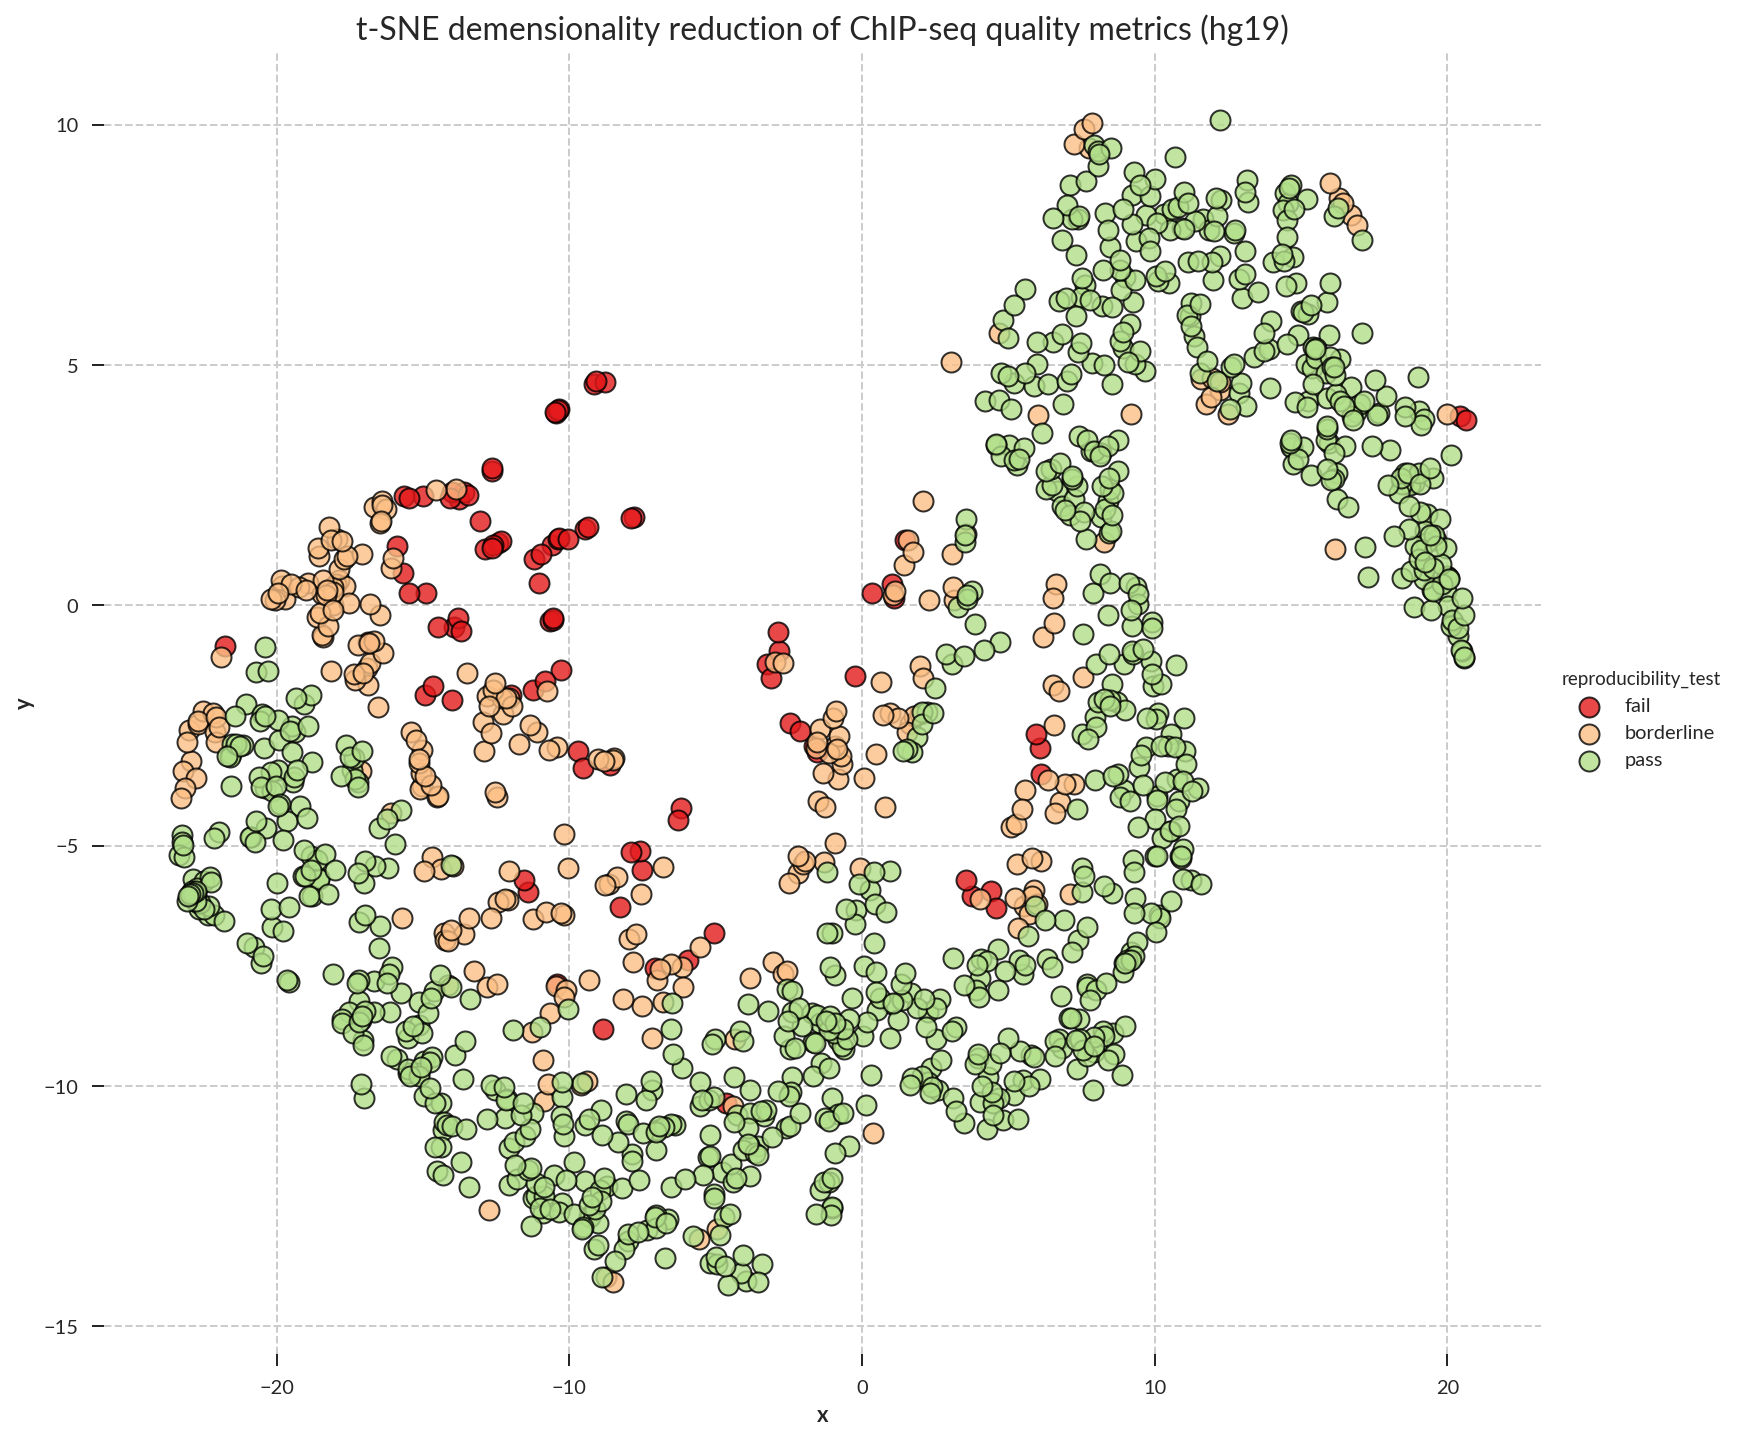

In [18]:
sns.set(style="ticks", font="Lato")
with sns.plotting_context("notebook", font_scale=1):
    sns.lmplot(x='x',
               y='y',
               hue='reproducibility_test',
               hue_order=['fail', 'borderline', 'pass'],
               data=data,
               size=10,
               aspect=1.1,
               fit_reg=False,
               palette=['#e41a1c','#fdc086','#b2df8a'],
               scatter_kws={'s': 100,
                            'linewidth': 1,
                            'edgecolor': "black"})
sns.despine(left=True, bottom=True)
sns.plt.gca().yaxis.grid(True, ls="--")
sns.plt.gca().xaxis.grid(True, ls="--")
y_label = sns.plt.gca().get_ylabel()
sns.plt.gca().set_ylabel(ylabel=y_label, weight='bold')
x_label = sns.plt.gca().get_xlabel()
sns.plt.gca().set_xlabel(xlabel=x_label, weight='bold')
sns.plt.title("t-SNE demensionality reduction of ChIP-seq quality metrics (hg19)", size=16, family='Lato');